In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats 

# eye candy plots
#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
# source https://github.com/dhaitz/matplotlib-stylesheets

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# machine-learning stack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PolynomialFeatures,
    FunctionTransformer
)

# Set figure stile and size for entire notebook
sns.set_style("ticks")
plt.rcParams["figure.figsize"] = (7,4)

%matplotlib inline

In [2]:
df = pd.read_csv('train.csv', sep = ",")

In [3]:
df.head(2)

Place_ID X Date        Date Place_ID  target  target_min  target_max  \
0  010Q650 X 2020-01-02  2020-01-02  010Q650    38.0        23.0        53.0   
1  010Q650 X 2020-01-03  2020-01-03  010Q650    39.0        25.0        63.0   

   target_variance  target_count  precipitable_water_entire_atmosphere  \
0           769.50            92                                  11.0   
1          1319.85            91                                  14.6   

   relative_humidity_2m_above_ground  ...  L3_SO2_sensor_zenith_angle  \
0                          60.200001  ...                   38.593017   
1                          48.799999  ...                   59.624912   

   L3_SO2_solar_azimuth_angle  L3_SO2_solar_zenith_angle  \
0                  -61.752587                  22.363665   
1                  -67.693509                  28.614804   

   L3_CH4_CH4_column_volume_mixing_ratio_dry_air  L3_CH4_aerosol_height  \
0                                    1793.793579            3227.855469   
1                                    1789.960449            3384.226562   

   L3_CH4_aerosol_optical_depth  L3_CH4_sensor_azimuth_angle  \
0                      0.010579                    74.481049   
1                      0.015104                    75.630043   

   L3_CH4_sensor_zenith_angle  L3_CH4_solar_azimuth_angle  \
0                   37.501499                  -62.142639   
1                   55.657486                  -53.868134   

   L3_CH4_solar_zenith_angle  
0                  22.545118  
1                  19.293652  

[2 rows x 82 columns]

In [4]:
df.shape

(30557, 82)

In [5]:
df.columns

Index(['Place_ID X Date', 'Date', 'Place_ID', 'target', 'target_min',
       'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle',
       'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle',
       'L3_NO2_solar_zenith_angle',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_O3_cloud_fraction', 'L3_O3_sensor_azimuth_angle',
   

<Axes: >

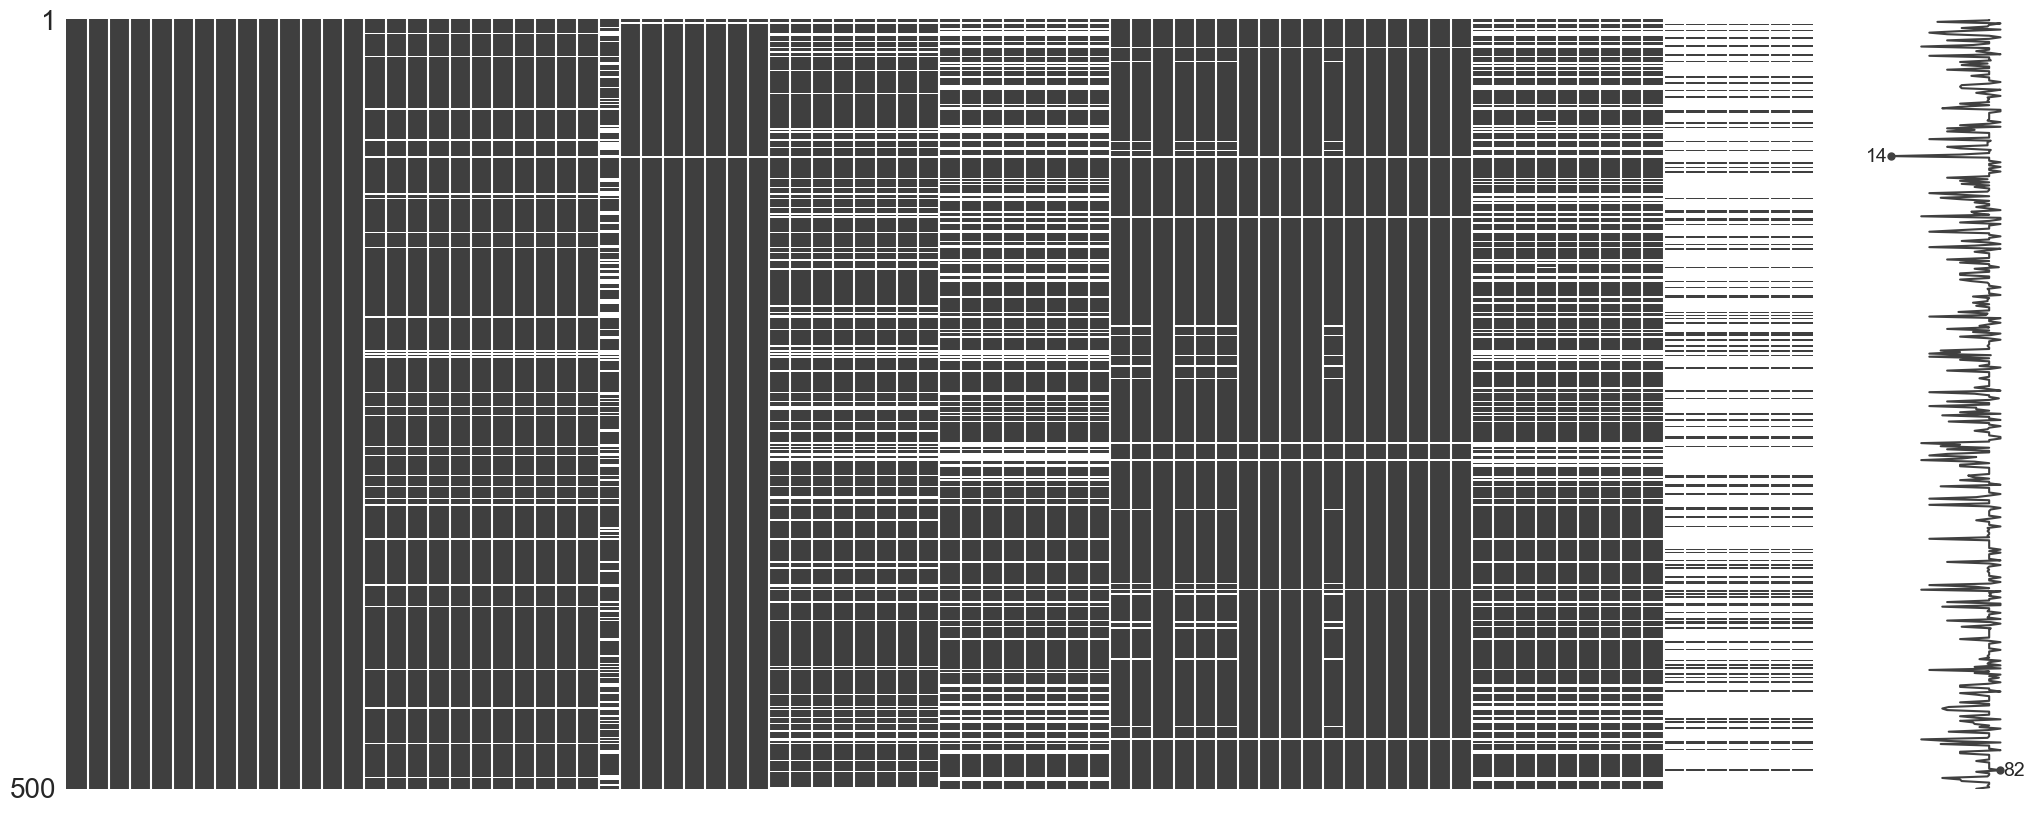

In [6]:
import missingno as msno
%matplotlib inline
msno.matrix(df.sample(500))

<Axes: >

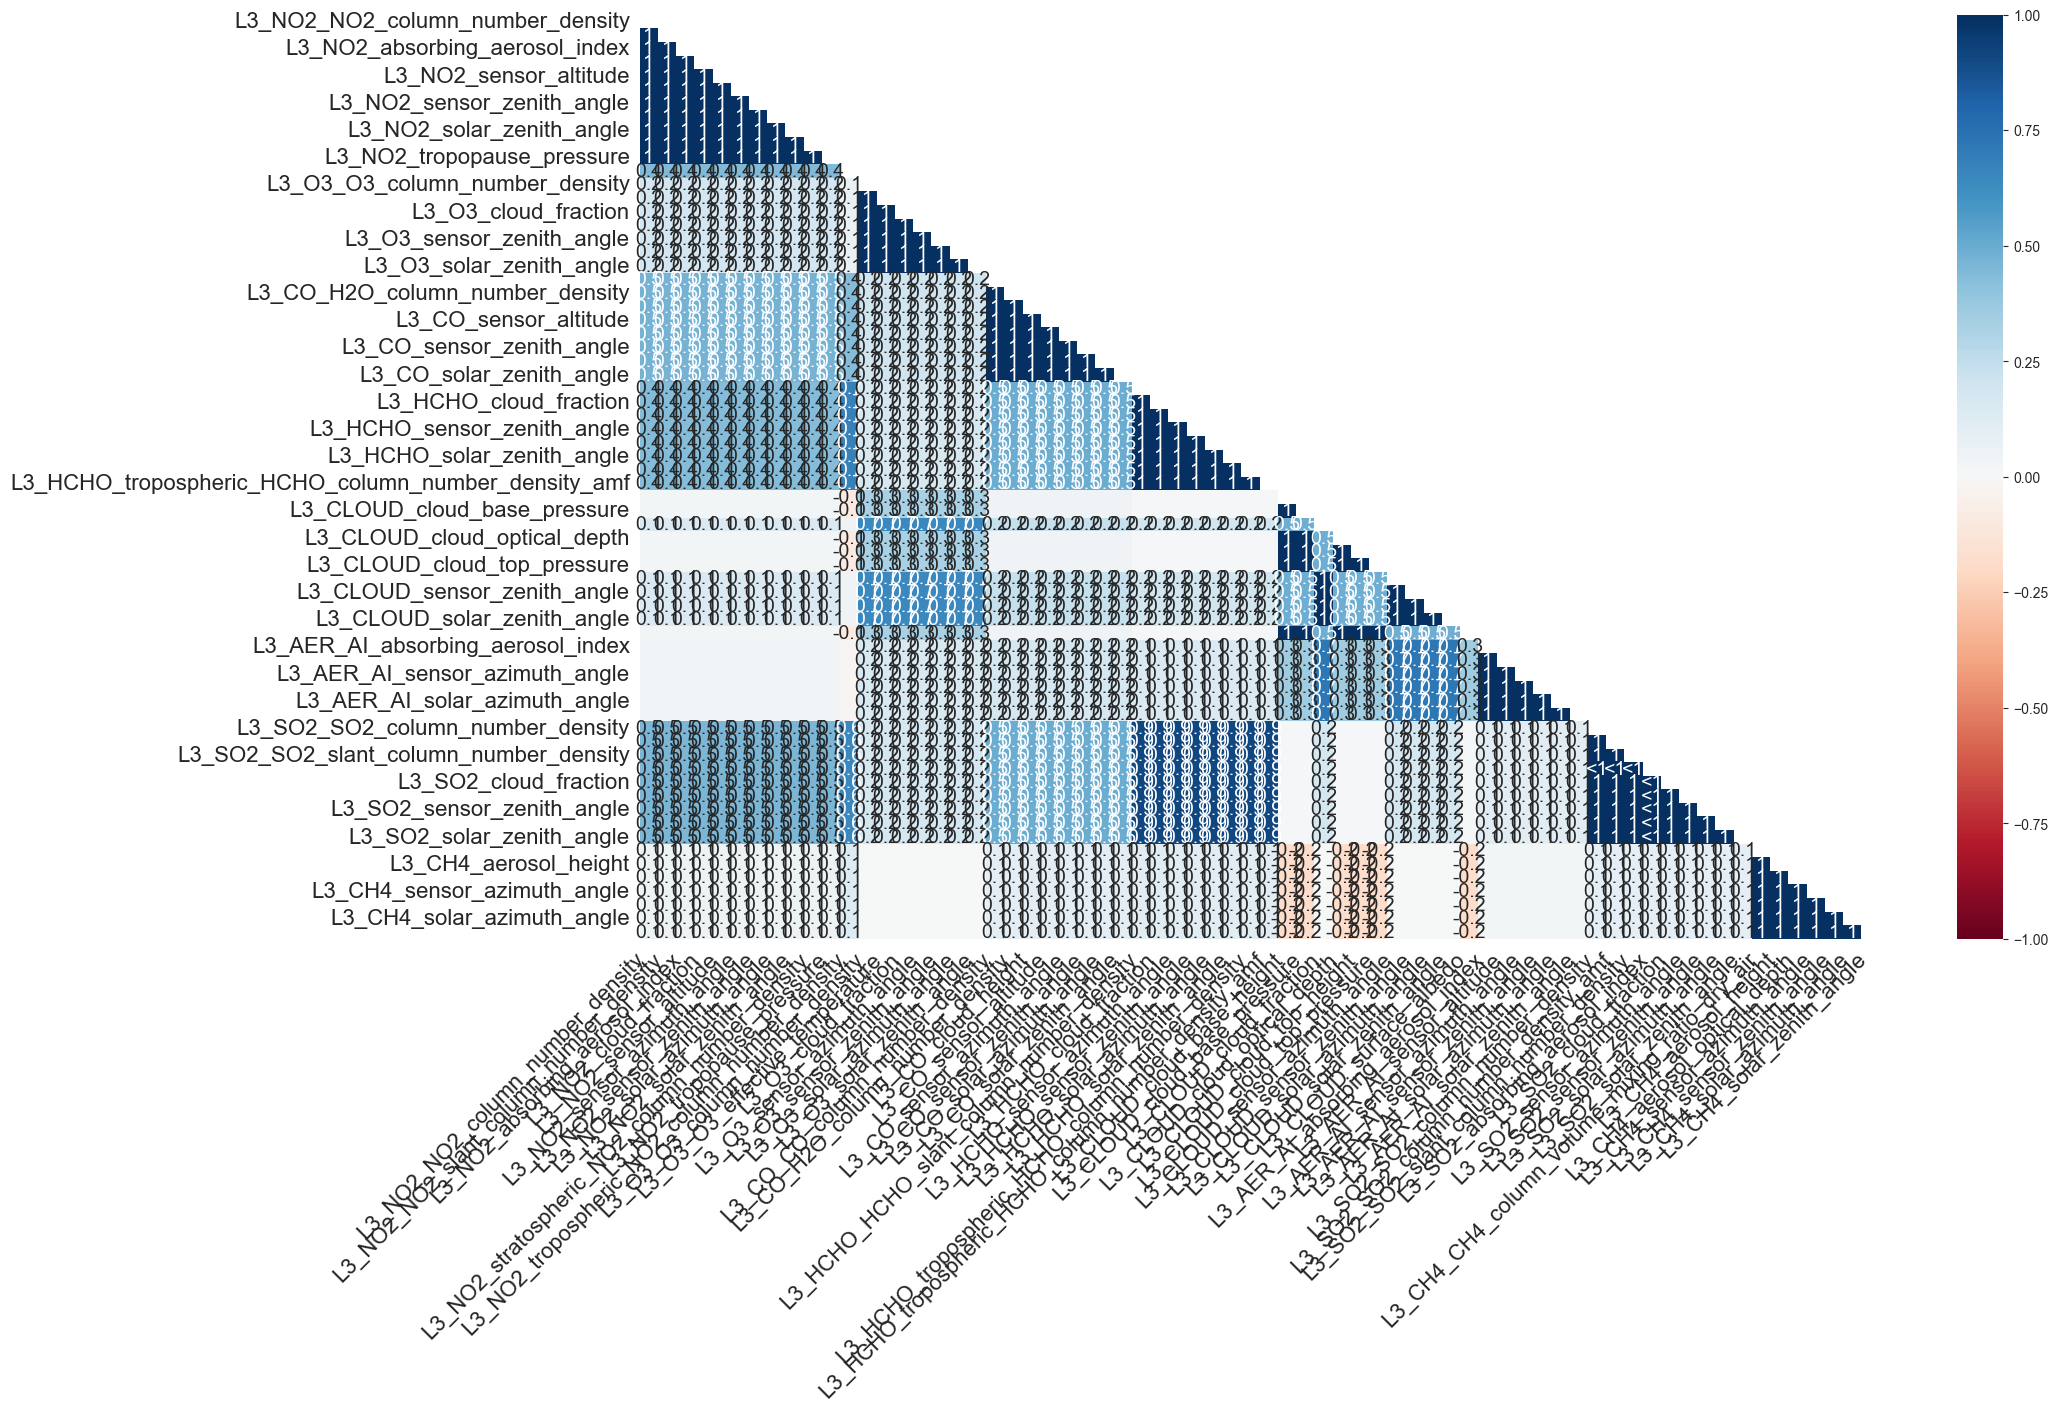

In [7]:
msno.heatmap(df)

In [8]:
# Drop the last 7 columns and there are TOO many missing values
list_drop_col = ['L3_CH4_CH4_column_volume_mixing_ratio_dry_air',
       'L3_CH4_aerosol_height', 'L3_CH4_aerosol_optical_depth',
       'L3_CH4_sensor_azimuth_angle', 'L3_CH4_sensor_zenith_angle',
       'L3_CH4_solar_azimuth_angle', 'L3_CH4_solar_zenith_angle']

newdf = df.drop(list_drop_col, axis='columns')


In [9]:
newdf.shape

(30557, 75)

<Axes: >

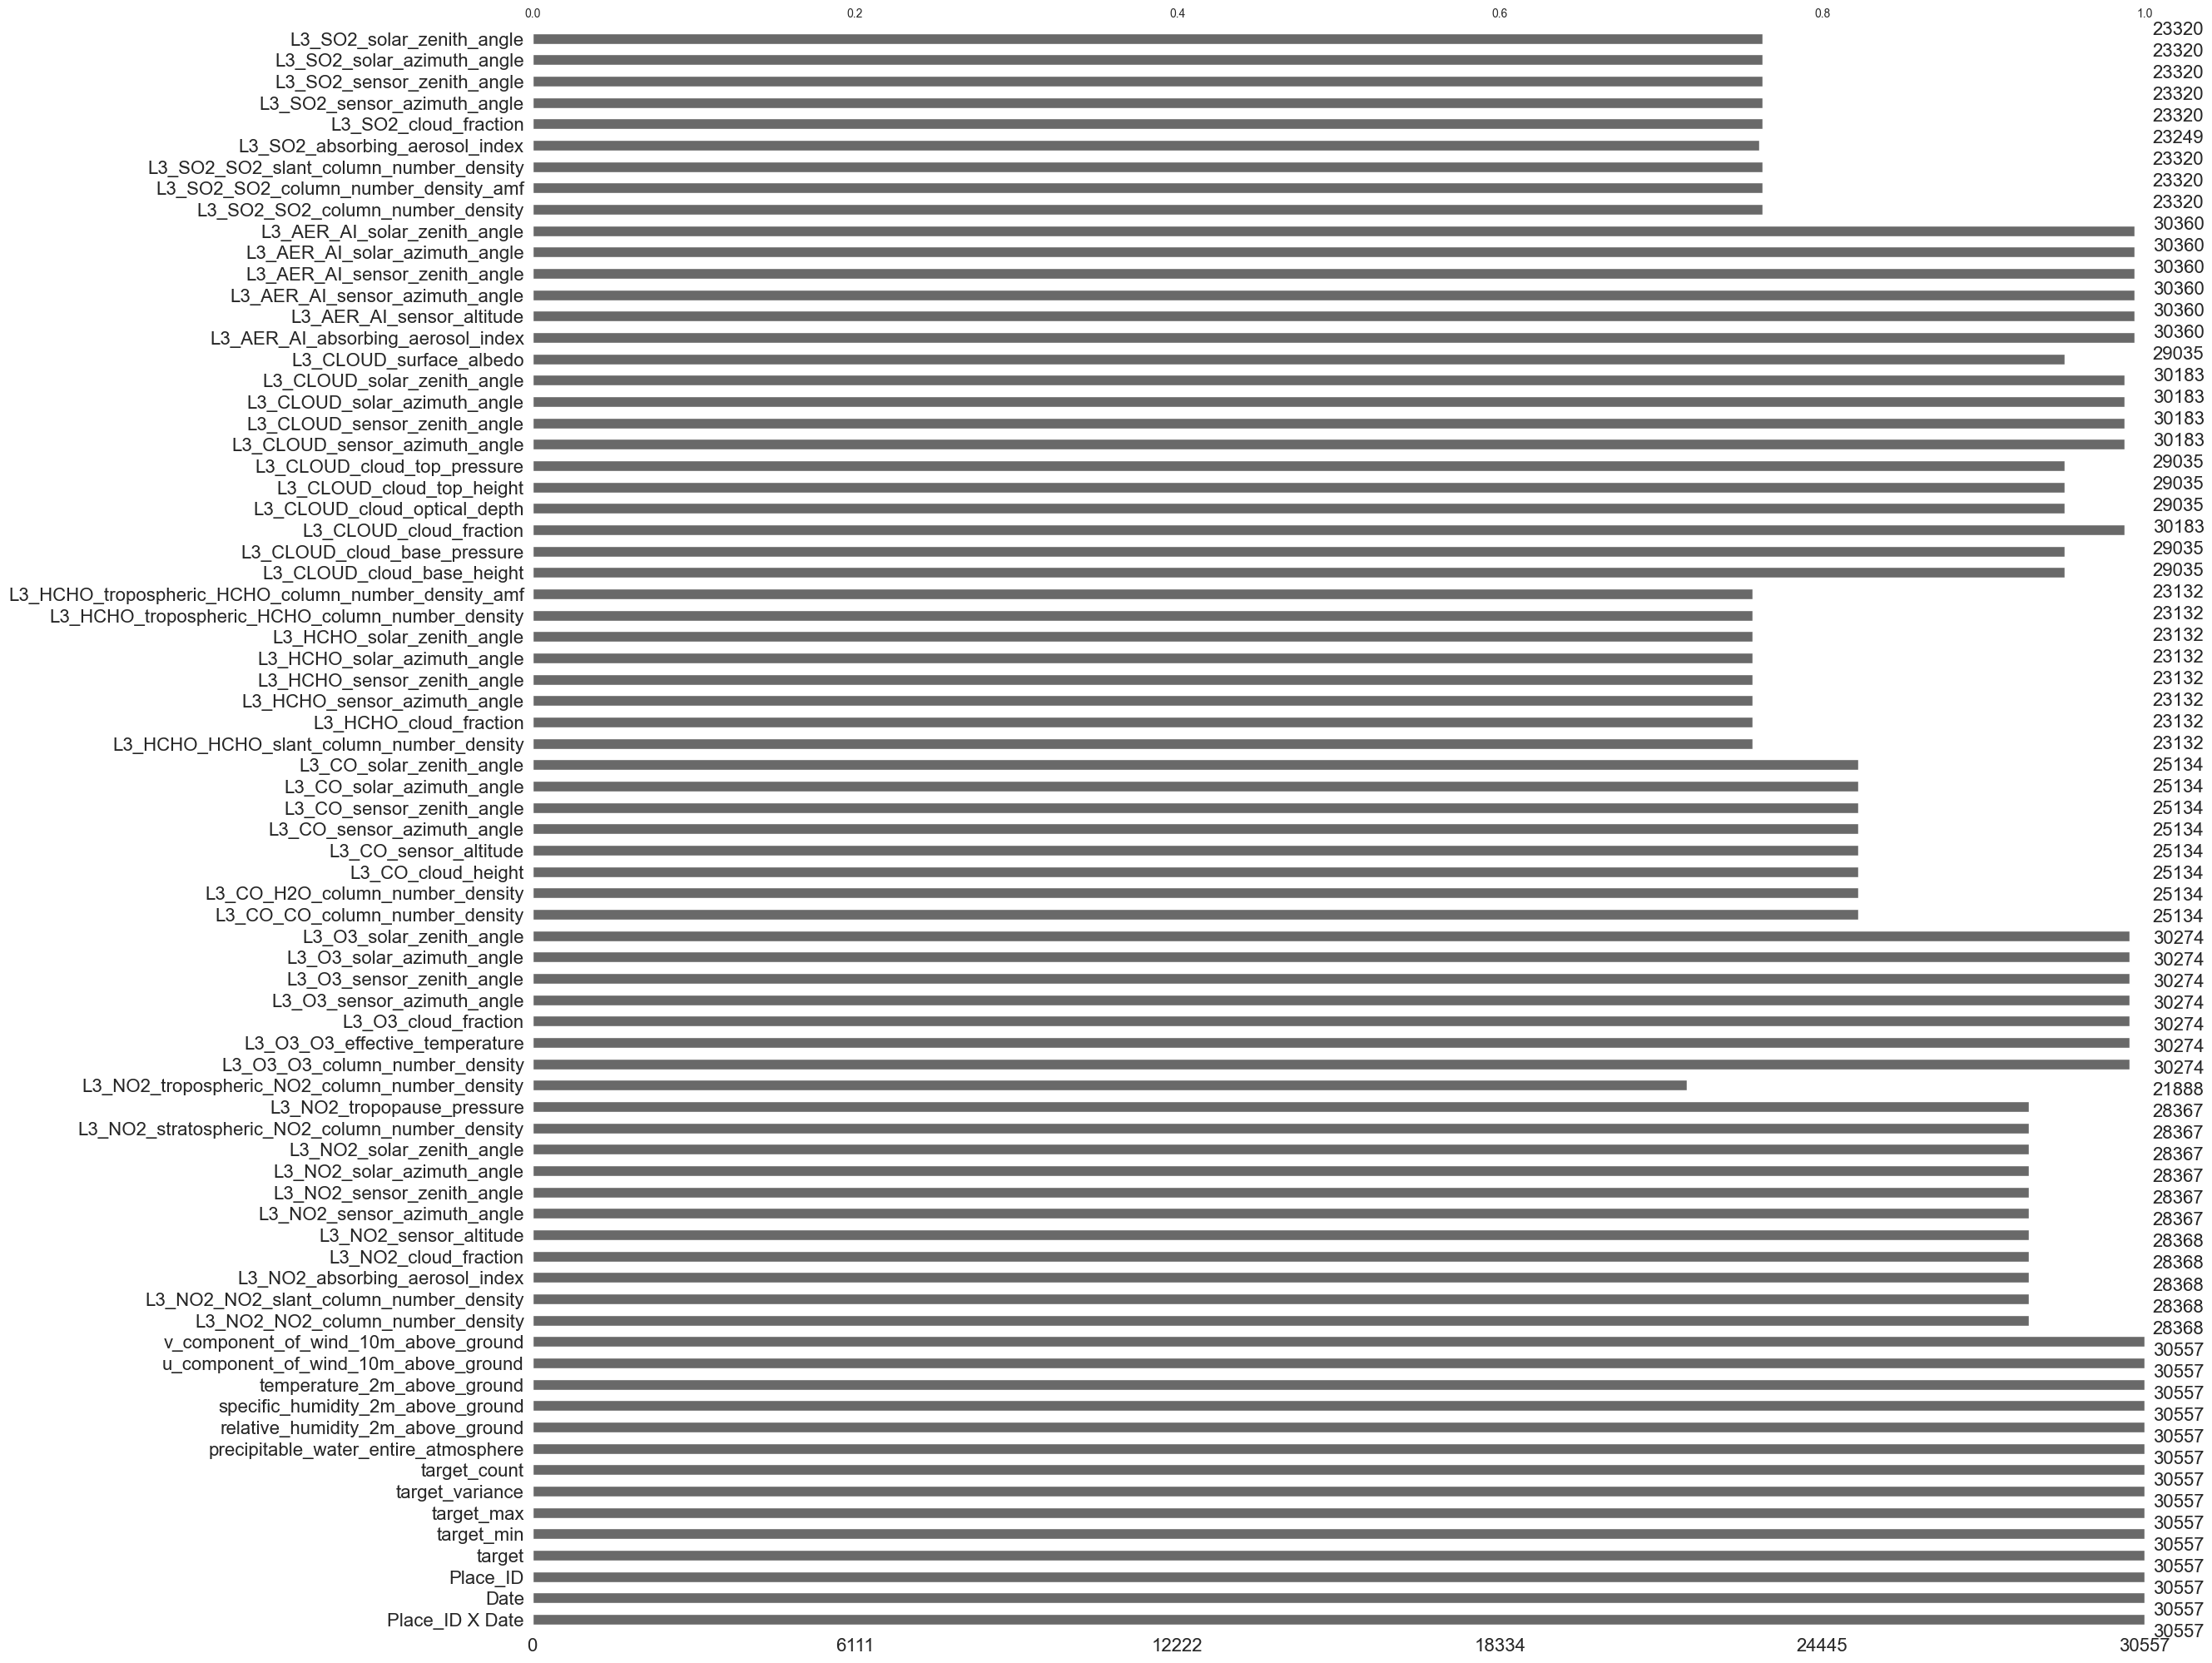

In [10]:
msno.bar(newdf)

In [11]:
# I see some small number of rows are missing almost everything excep columns 1 to 14 ..

threshold = 60  # for example, rows with more than 3 missing values

# Identify rows with more than `threshold` missing values
rows_with_many_missing = newdf[newdf.isnull().sum(axis=1) > threshold]

# View the rows with many missing values
len(rows_with_many_missing)

34

In [12]:
# Lets drop these 34
df_cleaned = newdf[newdf.isnull().sum(axis=1) <= threshold]
df_cleaned.shape

(30523, 75)

In [13]:
# Let us check 'precipitable_water_entire_atmosphere'
df_cleaned[['precipitable_water_entire_atmosphere','relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground']].describe().T

count       mean        std  \
precipitable_water_entire_atmosphere  30523.0  15.293773  10.683337   
relative_humidity_2m_above_ground     30523.0  70.541864  18.812620   
specific_humidity_2m_above_ground     30523.0   0.006001   0.003786   
temperature_2m_above_ground           30523.0   9.316051   9.344162   
u_component_of_wind_10m_above_ground  30523.0   0.413668   2.702307   
v_component_of_wind_10m_above_ground  30523.0   0.087025   2.640898   

                                            min        25%        50%  \
precipitable_water_entire_atmosphere   0.420044   7.661664  12.200000   
relative_humidity_2m_above_ground      5.128572  58.600002  74.099998   
specific_humidity_2m_above_ground      0.000139   0.003400   0.004910   
temperature_2m_above_ground          -34.647879   3.120365   8.472589   
u_component_of_wind_10m_above_ground -15.559646  -1.097886   0.219907   
v_component_of_wind_10m_above_ground -15.023647  -1.416743   0.011775   

                                            75%         max  
precipitable_water_entire_atmosphere  19.900000   72.599998  
relative_humidity_2m_above_ground     85.445457  100.000000  
specific_humidity_2m_above_ground      0.007560    0.021615  
temperature_2m_above_ground           16.200967   37.437921  
u_component_of_wind_10m_above_ground   1.768957   17.955124  
v_component_of_wind_10m_above_ground   1.553342   15.055530

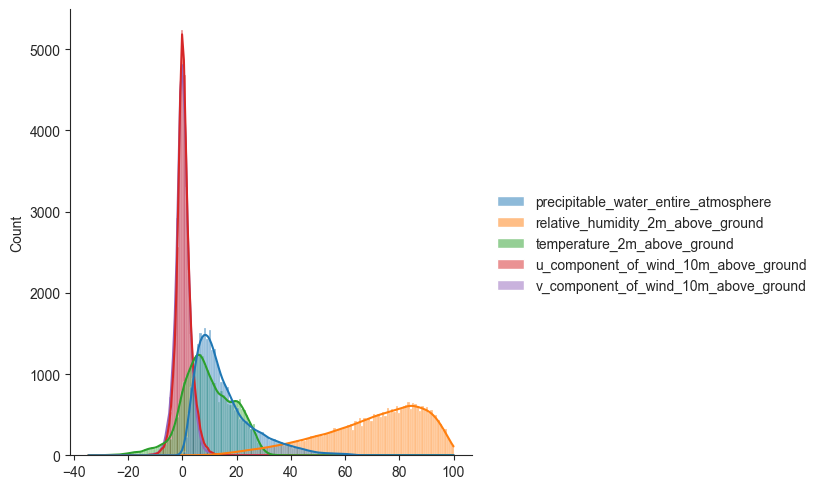

In [14]:
# check outliers and if normally distributed

#create normal distribution curve
sns.displot(df_cleaned[['precipitable_water_entire_atmosphere','relative_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground']], kde=True)

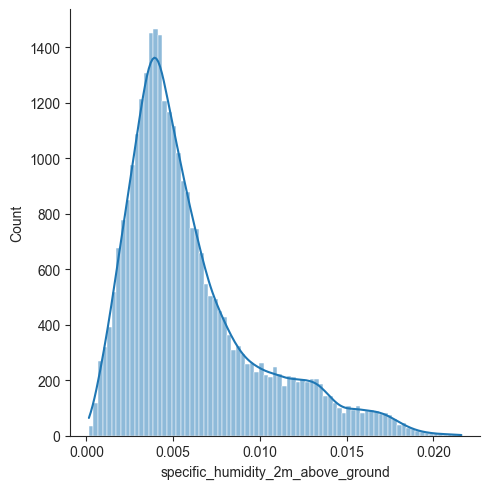

In [15]:
sns.displot(df_cleaned['specific_humidity_2m_above_ground'], kde=True)

In [16]:
# Since not normally distributed. Will need to normalization ( 0 to 1) and NOT standardization

In [17]:
# Note to self. These need to be normalised

# Z-Score normalization
# data['standardized'] = (df['columns'] - df['columns'].mean()) / df['columns'].std()

num_cat = [['precipitable_water_entire_atmosphere','relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground']]

In [18]:
binary_features = [XXXX]

NameError: name 'XXXX' is not defined

In [ ]:
ordinal_features = []

In [ ]:
cat_features = ['']

In [ ]:
num_features = []

In [ ]:
df_cleaned.columns

In [19]:
# Analyzing if there is relationship for the columns within a type of Gass and particulates.
# E.g. do we need the Azuth satellite angle etc?

df.iloc[:,14:26].shape # separates out just the L3_NO2 columns
df_NO2 = df.iloc[:,14:26]

# Add back the target column
df_NO2['target'] = df_cleaned['target']

In [20]:
df_NO2.shape

(30557, 13)

In [21]:
columns_to_test= ['L3_NO2_sensor_azimuth_angle',
       'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle',
       'L3_NO2_solar_zenith_angle', 'target']

In [22]:
df_NO2_azi = df_NO2[columns_to_test]
df_NO2_azi.columns

Index(['L3_NO2_sensor_azimuth_angle', 'L3_NO2_sensor_zenith_angle',
       'L3_NO2_solar_azimuth_angle', 'L3_NO2_solar_zenith_angle', 'target'],
      dtype='object')

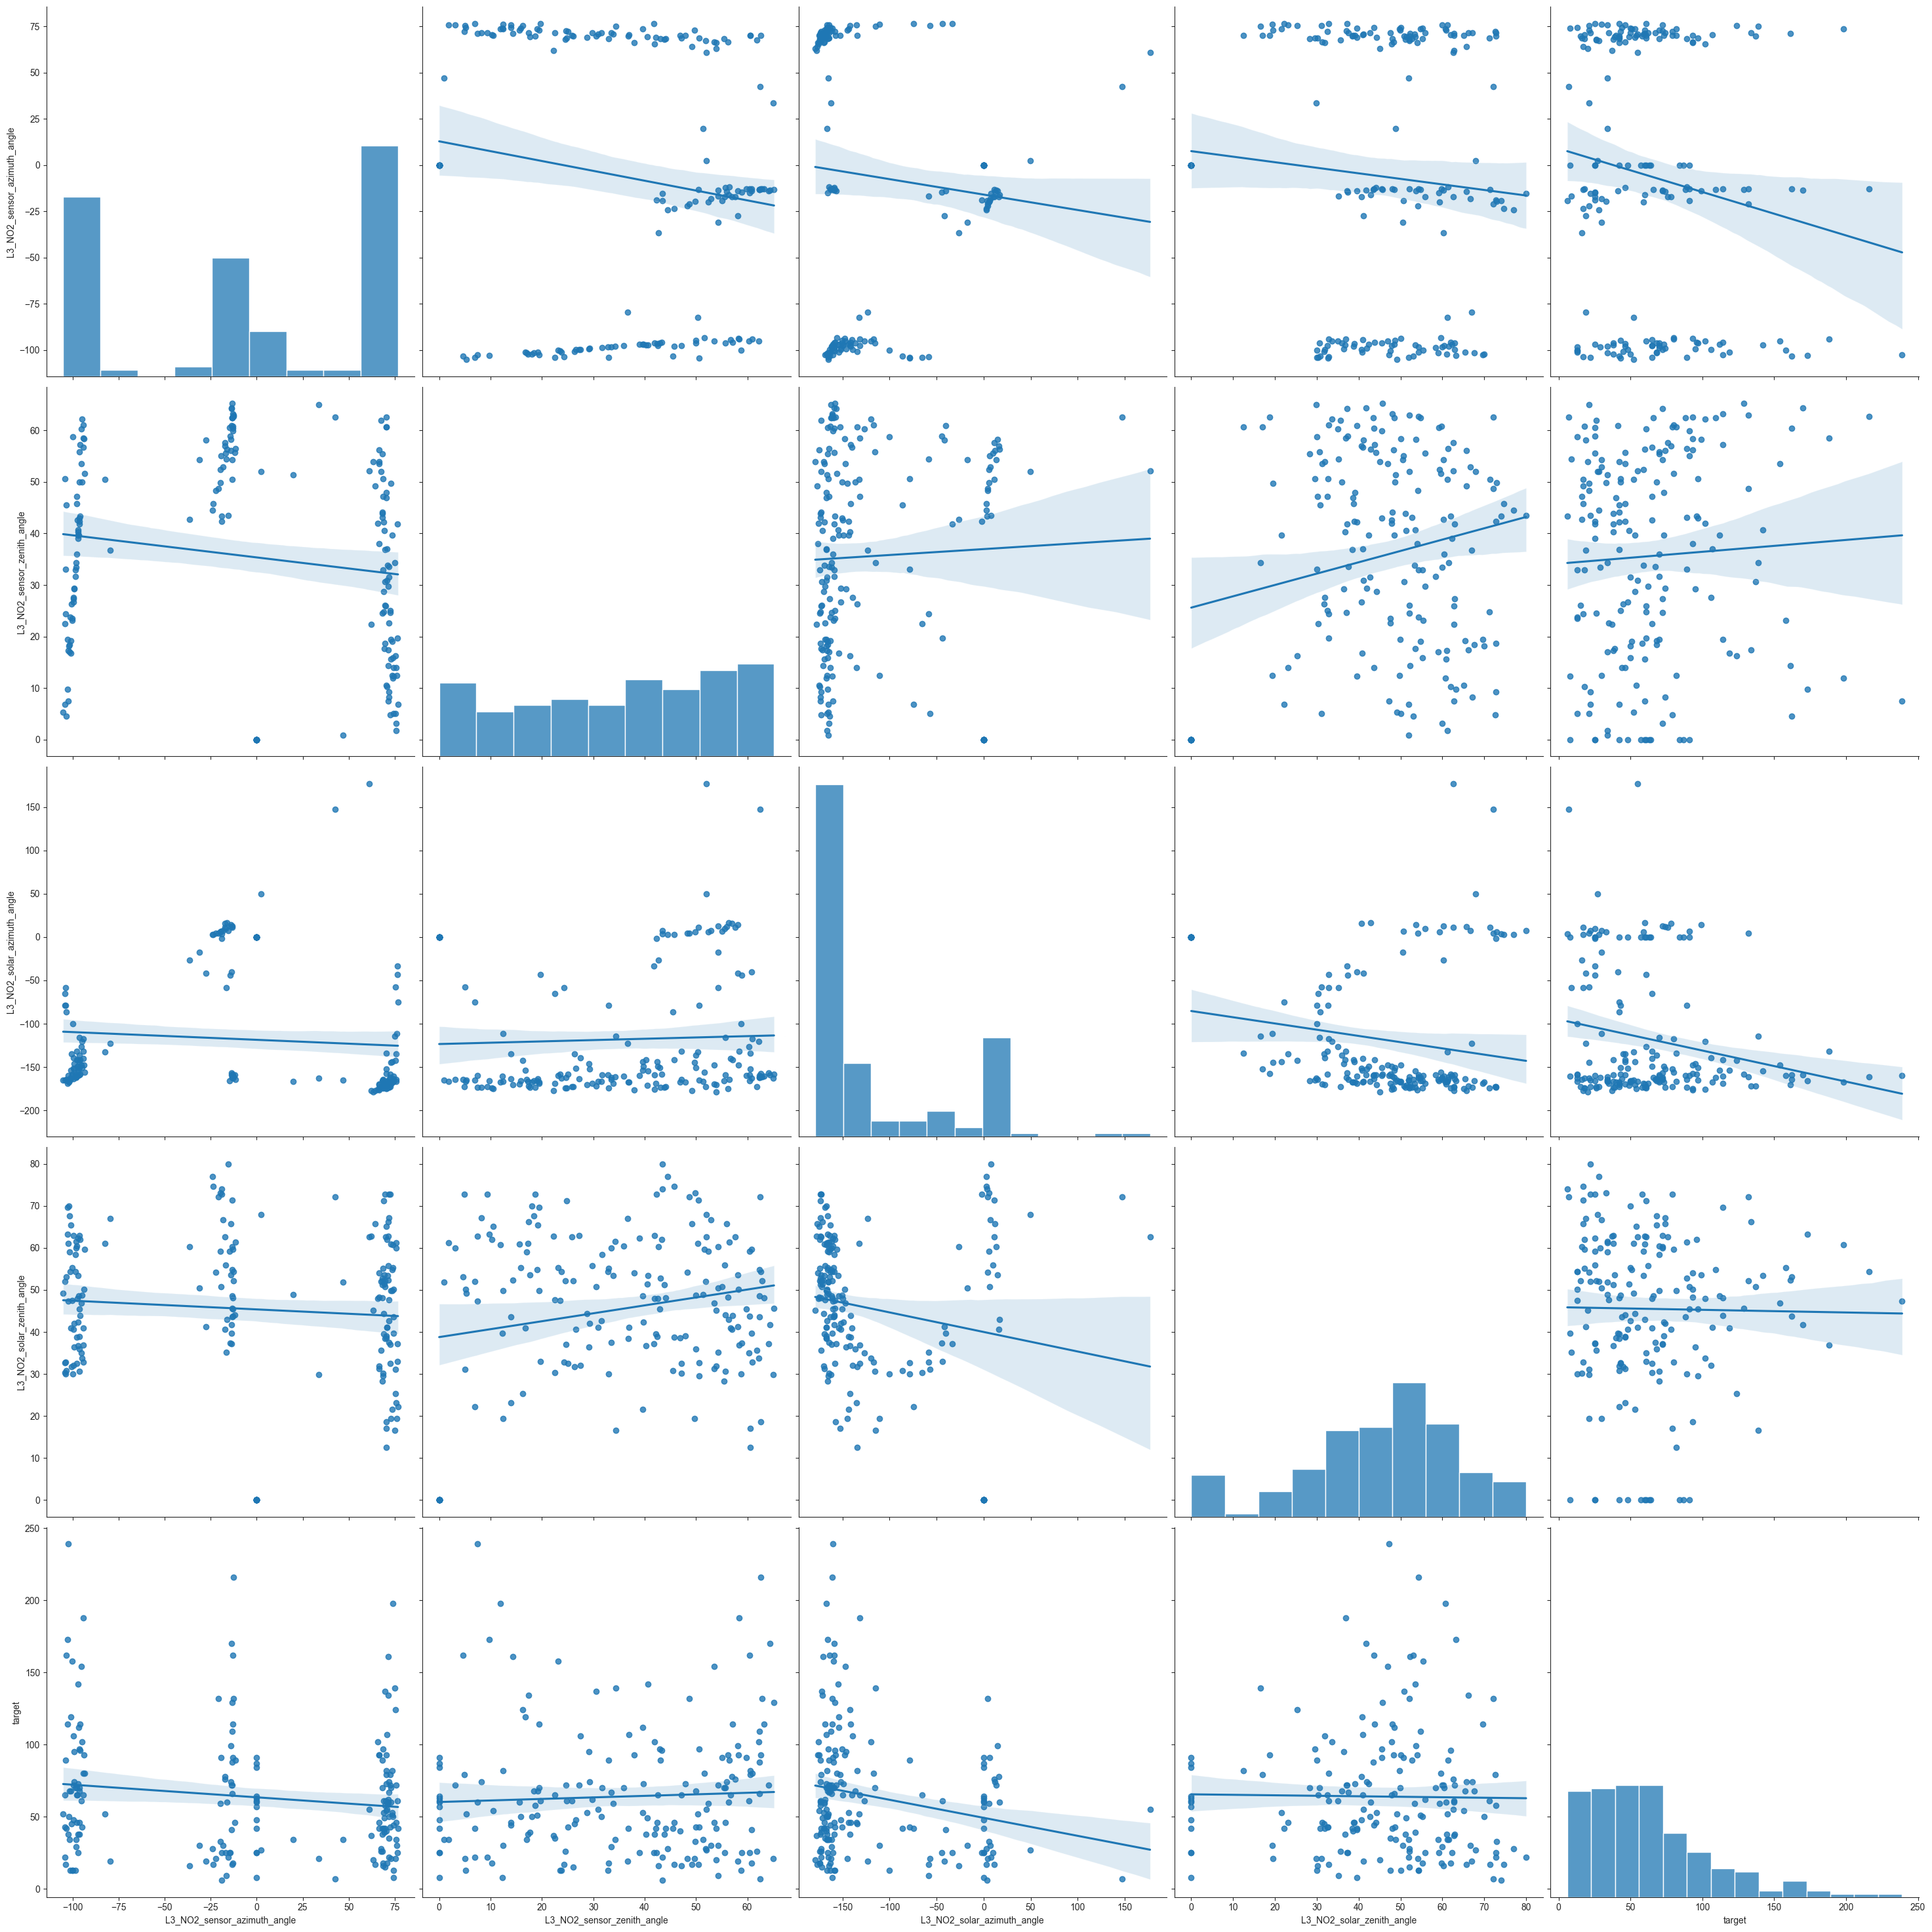

In [23]:
df_NO2_azi_sample = df_NO2_azi.sample(200, random_state=42)
sns.pairplot(df_NO2_azi_sample,kind='reg', height = 6)

In [24]:
df_NO2_azi.corr()

L3_NO2_sensor_azimuth_angle  \
L3_NO2_sensor_azimuth_angle                     1.000000   
L3_NO2_sensor_zenith_angle                     -0.021971   
L3_NO2_solar_azimuth_angle                     -0.021555   
L3_NO2_solar_zenith_angle                      -0.102639   
target                                          0.003722   

                             L3_NO2_sensor_zenith_angle  \
L3_NO2_sensor_azimuth_angle                   -0.021971   
L3_NO2_sensor_zenith_angle                     1.000000   
L3_NO2_solar_azimuth_angle                     0.023875   
L3_NO2_solar_zenith_angle                      0.341139   
target                                         0.037475   

                             L3_NO2_solar_azimuth_angle  \
L3_NO2_sensor_azimuth_angle                   -0.021555   
L3_NO2_sensor_zenith_angle                     0.023875   
L3_NO2_solar_azimuth_angle                     1.000000   
L3_NO2_solar_zenith_angle                     -0.276394   
target                                        -0.177861   

                             L3_NO2_solar_zenith_angle    target  
L3_NO2_sensor_azimuth_angle                  -0.102639  0.003722  
L3_NO2_sensor_zenith_angle                    0.341139  0.037475  
L3_NO2_solar_azimuth_angle                   -0.276394 -0.177861  
L3_NO2_solar_zenith_angle                     1.000000  0.001192  
target                                        0.001192  1.000000

## So conclusion here is to drop all columns for "azimuth" and "zenith"

In [25]:
df_cleaned = df_cleaned.drop(columns=[col for col in df_cleaned.columns if 'azimuth' in col or 'zenith' in col])

In [26]:
df_cleaned.shape

(30523, 47)

In [27]:
## Drop the 2 altitude columns that Okan identified as not relevant (Keeping one which had a negative 0.3 correlation for now)

In [28]:
df_cleaned = df_cleaned.drop(columns=['L3_NO2_sensor_altitude', 'L3_CO_sensor_altitude'])
df_cleaned.shape

(30523, 45)

In [29]:
null_counts = df_cleaned.isnull().sum()
null_percentage = (df_cleaned.isnull().mean() * 100) #this works since its 1,0 binary true and false whether it is null or not. so mean is just the count of 1s divided by sum of the rows
null_summary = pd.DataFrame({
    'null_count' : null_counts,
    'null_percentage': null_percentage})
null_summary = null_summary.sort_values('null_percentage', ascending=False)

null_summary

null_count  \
L3_NO2_tropospheric_NO2_column_number_density             8635   
L3_HCHO_tropospheric_HCHO_column_number_density...        7391   
L3_HCHO_HCHO_slant_column_number_density                  7391   
L3_HCHO_cloud_fraction                                    7391   
L3_HCHO_tropospheric_HCHO_column_number_density           7391   
L3_SO2_absorbing_aerosol_index                            7274   
L3_SO2_cloud_fraction                                     7203   
L3_SO2_SO2_slant_column_number_density                    7203   
L3_SO2_SO2_column_number_density_amf                      7203   
L3_SO2_SO2_column_number_density                          7203   
L3_CO_H2O_column_number_density                           5389   
L3_CO_CO_column_number_density                            5389   
L3_CO_cloud_height                                        5389   
L3_NO2_tropopause_pressure                                2156   
L3_NO2_stratospheric_NO2_column_number_density            2156   
L3_NO2_cloud_fraction                                     2155   
L3_NO2_absorbing_aerosol_index                            2155   
L3_NO2_NO2_slant_column_number_density                    2155   
L3_NO2_NO2_column_number_density                          2155   
L3_CLOUD_cloud_top_height                                 1488   
L3_CLOUD_surface_albedo                                   1488   
L3_CLOUD_cloud_base_height                                1488   
L3_CLOUD_cloud_base_pressure                              1488   
L3_CLOUD_cloud_optical_depth                              1488   
L3_CLOUD_cloud_top_pressure                               1488   
L3_CLOUD_cloud_fraction                                    340   
L3_O3_O3_effective_temperature                             249   
L3_O3_cloud_fraction                                       249   
L3_O3_O3_column_number_density                             249   
L3_AER_AI_sensor_altitude                                  163   
L3_AER_AI_absorbing_aerosol_index                          163   
target_variance                                              0   
Place_ID                                                     0   
target                                                       0   
target_min                                                   0   
target_max                                                   0   
target_count                                                 0   
Date                                                         0   
precipitable_water_entire_atmosphere                         0   
relative_humidity_2m_above_ground                            0   
specific_humidity_2m_above_ground                            0   
temperature_2m_above_ground                                  0   
u_component_of_wind_10m_above_ground                         0   
v_component_of_wind_10m_above_ground                         0   
Place_ID X Date                                              0   

                                                    null_percentage  
L3_NO2_tropospheric_NO2_column_number_density             28.290142  
L3_HCHO_tropospheric_HCHO_column_number_density...        24.214527  
L3_HCHO_HCHO_slant_column_number_density                  24.214527  
L3_HCHO_cloud_fraction                                    24.214527  
L3_HCHO_tropospheric_HCHO_column_number_density           24.214527  
L3_SO2_absorbing_aerosol_index                            23.831209  
L3_SO2_cloud_fraction                                     23.598598  
L3_SO2_SO2_slant_column_number_density                    23.598598  
L3_SO2_SO2_column_number_density_amf                      23.598598  
L3_SO2_SO2_column_number_density                          23.598598  
L3_CO_H2O_column_number_density                           17.655538  
L3_CO_CO_column_number_density                            17.655538  
L3_CO_cloud_height                                        17.655538  
L3_NO2_tropopause_pressure         

In [30]:
from sklearn.ensemble import RandomForestRegressor

Ximp = df_cleaned.drop(columns=['target','Place_ID X Date', 'Date', 'Place_ID','target_min',
       'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',])
Yimp = df_cleaned['target']

# Initialize and train the model
model = RandomForestRegressor(random_state=42)  # Added random_state for reproducibility
model.fit(Ximp, Yimp)

# Get feature importances
importance = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': Ximp.columns, 'Importance': importance})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or display the DataFrame
print(feature_importance_df)

                                              Feature  Importance
10                     L3_CO_CO_column_number_density    0.173256
25                          L3_AER_AI_sensor_altitude    0.115569
1              L3_NO2_NO2_slant_column_number_density    0.090127
15    L3_HCHO_tropospheric_HCHO_column_number_density    0.054605
23                            L3_CLOUD_surface_albedo    0.043031
16  L3_HCHO_tropospheric_HCHO_column_number_densit...    0.037995
11                    L3_CO_H2O_column_number_density    0.035909
20                       L3_CLOUD_cloud_optical_depth    0.035845
8                      L3_O3_O3_effective_temperature    0.033849
0                    L3_NO2_NO2_column_number_density    0.030413
7                      L3_O3_O3_column_number_density    0.025748
5                          L3_NO2_tropopause_pressure    0.025231
24                  L3_AER_AI_absorbing_aerosol_index    0.022743
4      L3_NO2_stratospheric_NO2_column_number_density    0.020604
6       L3

In [31]:
# Identify rows with NO missing data
rows_without_many_missing = df_cleaned[df_cleaned.isnull().sum(axis=1) == 0]

# View the rows with many missing values
len(rows_without_many_missing)

18219

In [32]:
df_cleaned.duplicated().sum()

np.int64(0)

In [33]:
num_cat = [['precipitable_water_entire_atmosphere','relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground']]


In [34]:
df_cleaned.to_csv('Train_cleaned.csv', index=False)

In [35]:
# Check group by City and see if the dates are in order
len(df_cleaned.groupby('Place_ID')['Date'])

340

In [36]:
print(df_cleaned['Date'].dtype)

object


In [37]:
df_cleaned['Date_DT'] = pd.to_datetime(df_cleaned['Date'])

In [38]:
new_columns = ['Place_ID X Date', 'Date_DT', 'Place_ID', 'target', 'target_min',
       'target_max', 'target_variance', 'target_count',
       'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_O3_cloud_fraction', 'L3_CO_CO_column_number_density',
       'L3_CO_H2O_column_number_density', 'L3_CO_cloud_height',
       'L3_HCHO_HCHO_slant_column_number_density', 'L3_HCHO_cloud_fraction',
       'L3_HCHO_tropospheric_HCHO_column_number_density',
       'L3_HCHO_tropospheric_HCHO_column_number_density_amf',
       'L3_CLOUD_cloud_base_height', 'L3_CLOUD_cloud_base_pressure',
       'L3_CLOUD_cloud_fraction', 'L3_CLOUD_cloud_optical_depth',
       'L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_top_pressure',
       'L3_CLOUD_surface_albedo', 'L3_AER_AI_absorbing_aerosol_index',
       'L3_AER_AI_sensor_altitude', 'L3_SO2_SO2_column_number_density',
       'L3_SO2_SO2_column_number_density_amf',
       'L3_SO2_SO2_slant_column_number_density',
       'L3_SO2_absorbing_aerosol_index', 'L3_SO2_cloud_fraction' ]

df_cleaned = df_cleaned[new_columns]

In [39]:
df_cleaned['Date_DT'].dtype

dtype('<M8[ns]')

In [40]:
df_cleaned['Place_ID'].unique()

array(['010Q650', '05EC30X', '0DPWHX8', '0GBXTHY', '0HYPV1N', '0I2XREH',
       '0KV6RJ1', '0MGEY68', '0O9R6AD', '0PP73FZ', '0RYZQUU', '0TFOCOS',
       '0TLH9UN', '11WPGRD', '168B2T2', '1GZGJPN', '1LC5FAK', '1PRBF5P',
       '1RYCZPT', '1SC5AWD', '1SKLTGJ', '1TE1HKJ', '1UEYEJQ', '1VN0K1S',
       '1WD100Y', '1X421B8', '1Y0S7TZ', '1YXF6T3', '1Z0FIHB', '1ZBVIMD',
       '215BUAP', '22D7H7I', '238N4KU', '28OSFYU', '2JZW8ZM', '2OR3E6X',
       '2S8UY1N', '2T41T7C', '2USU80I', '2WABRKJ', '35YN53B', '37VXILV',
       '3EJ33BJ', '3H1DEPM', '3HTVI1M', '3MXSVYJ', '3V177MC', '3WZQJU8',
       '4085G7L', '426FKUG', '431JQGO', '4EVR9T8', '4IVJPF2', '4WA4C0T',
       '4XP6UOX', '4ZMC9UQ', '50JFNAG', '57GIW0H', '5ETAG9S', '5I4TI4R',
       '5IOL334', '5IUK9TG', '5KE9R9R', '5M7ZX94', '5QYHA81', '5SXR1G0',
       '5YBO7PQ', '62HOUYZ', '693EWQR', '6CR3BYP', '6HXPCBH', '6J4AKCJ',
       '6KAHP8X', '6KHIOQ8', '6O56XQX', '6PWJJ6D', '6SJG8N2', '6TF1KNR',
       '6TLEFED', '6U70TX5', '73GXFXK', '7DRFQCK', 

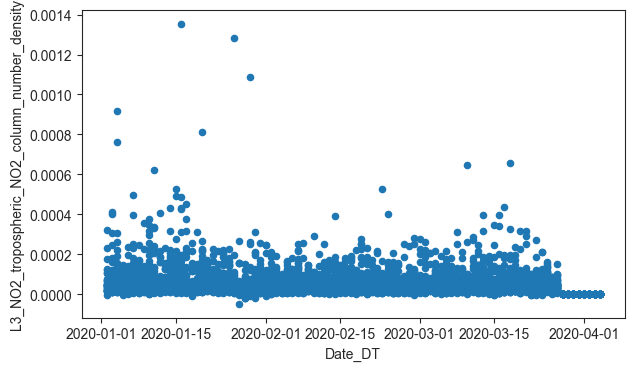

In [41]:
import matplotlib.pyplot as plt
# if taken random from across locations. seems all days are somewhat covered
df_cleaned_sample = df_cleaned.sample(5000, random_state=42)
df_cleaned_sample.plot(kind= 'scatter', x = 'Date_DT', y = 'L3_NO2_tropospheric_NO2_column_number_density')
plt.show()

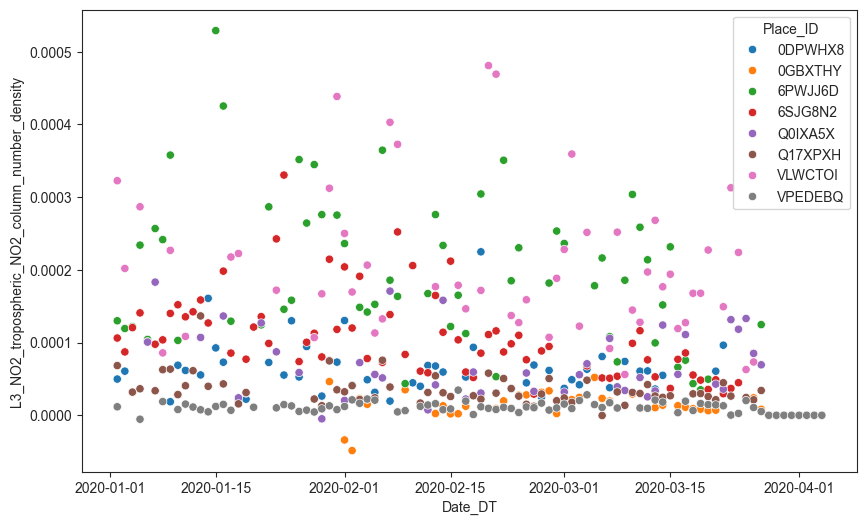

In [42]:
locations_sample = ['Q0IXA5X', 'Q17XPXH','VLWCTOI', 'VPEDEBQ','6PWJJ6D', '6SJG8N2','0DPWHX8', '0GBXTHY']
df_cleaned_sample_locations = df_cleaned[df_cleaned['Place_ID'].isin(locations_sample)]
# Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned_sample_locations, x='Date_DT', y='L3_NO2_tropospheric_NO2_column_number_density', 
                hue='Place_ID', palette='tab10')
plt.xlabel('Date_DT')
plt.ylabel('L3_NO2_tropospheric_NO2_column_number_density')
plt.legend(title='Place_ID')
plt.show() 	

<Axes: >

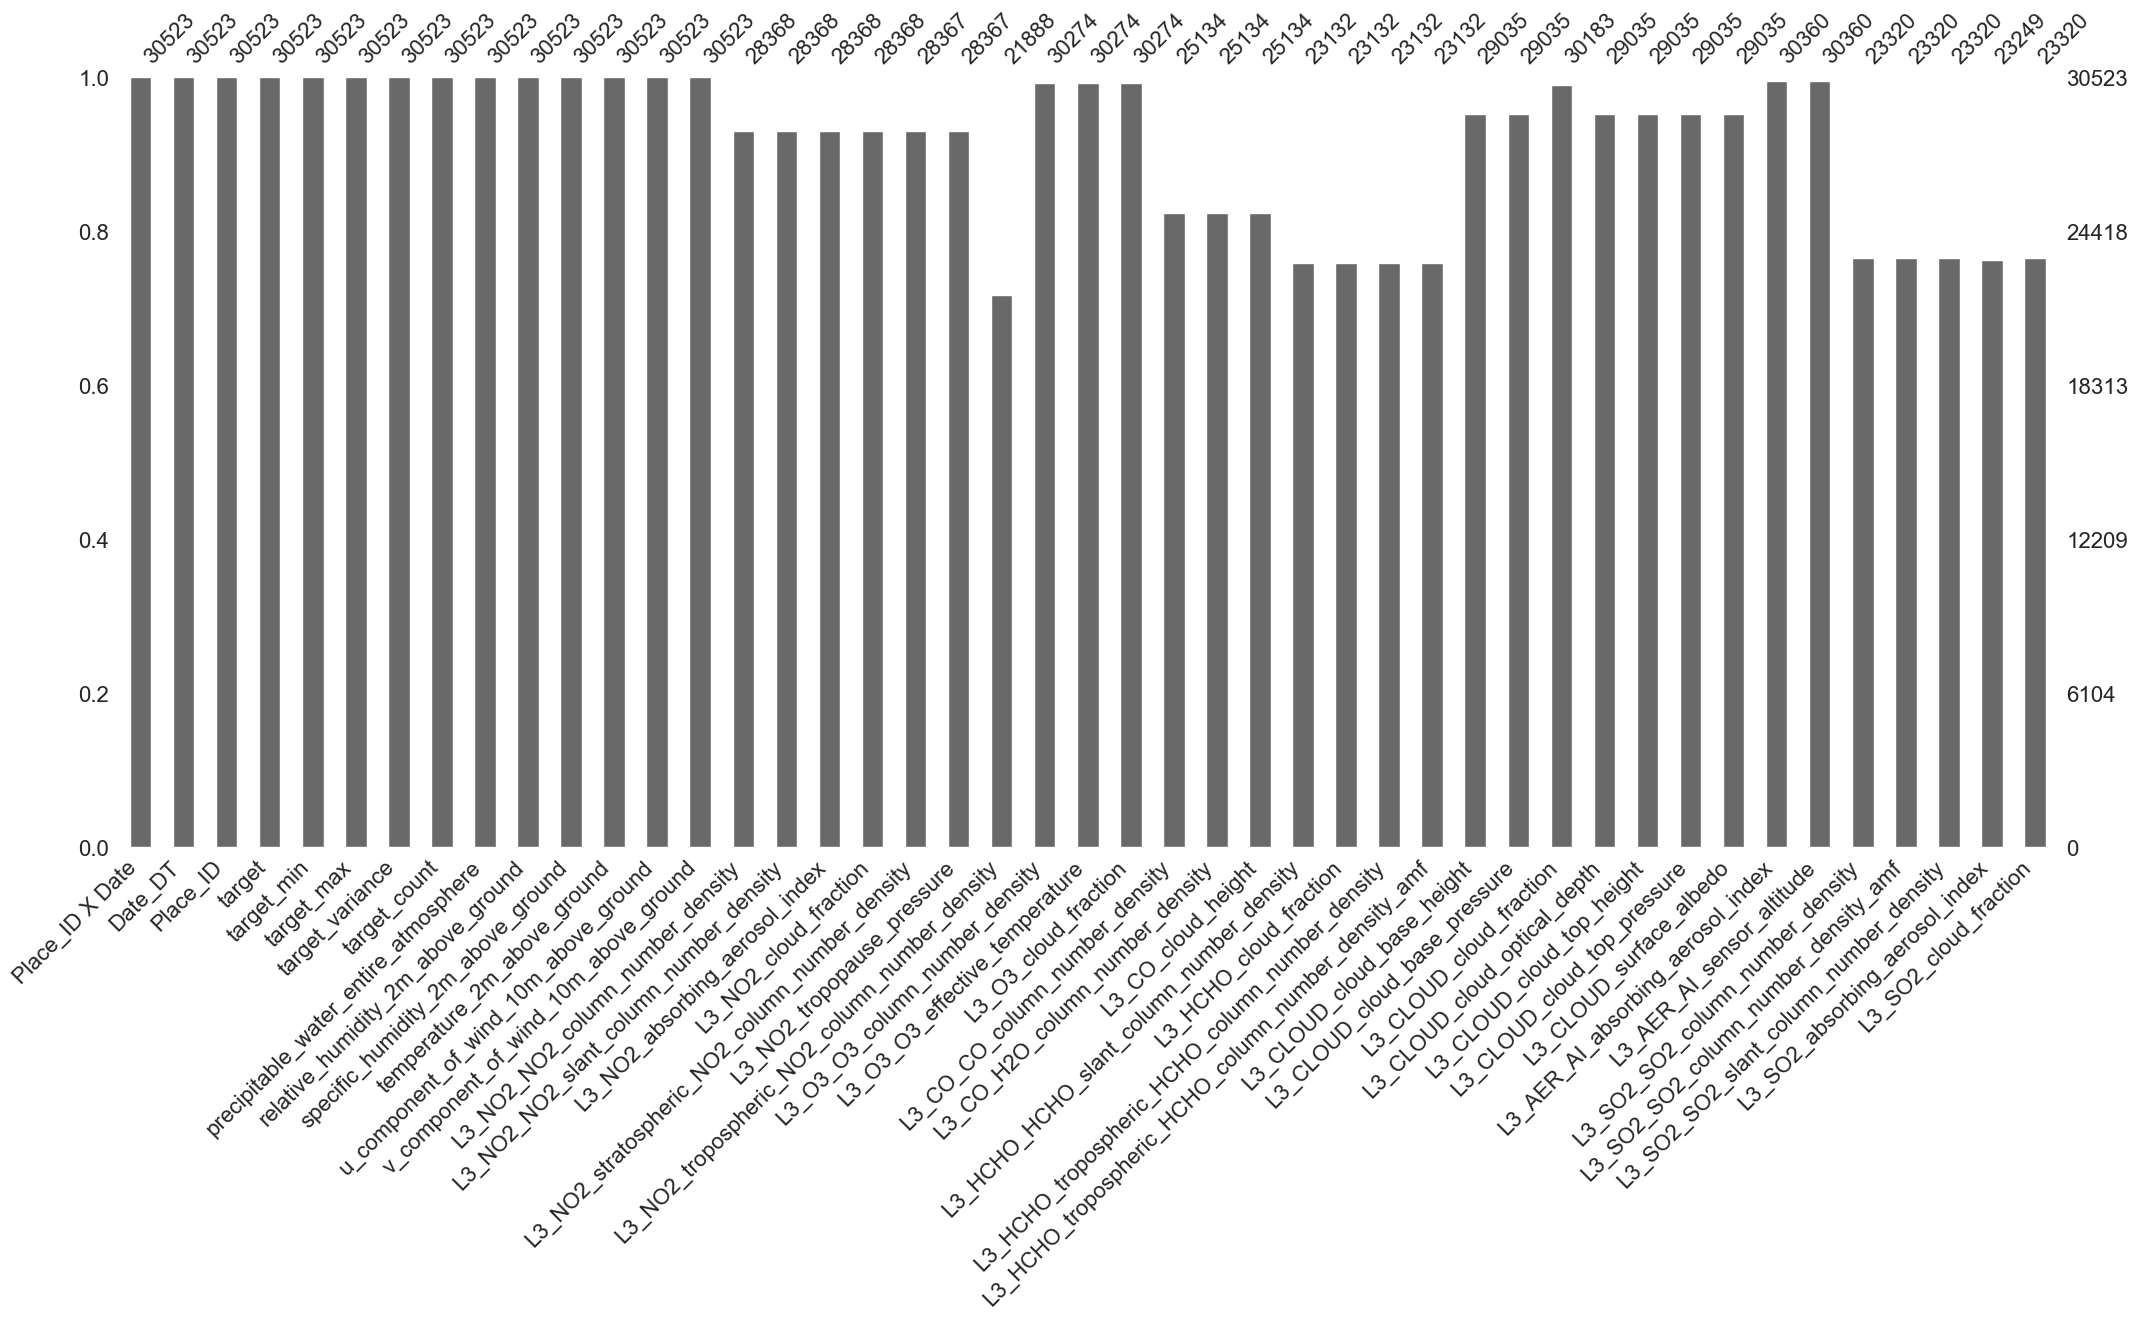

In [43]:
msno.bar(df_cleaned)

In [44]:
print(df_cleaned['L3_NO2_NO2_column_number_density'].corr(df_cleaned['L3_NO2_tropospheric_NO2_column_number_density']))

0.9322466367594486


In [45]:
## Drop 'L3_NO2_tropospheric_NO2_column_number_density' as lots missing data and anyway 93% correlated to L3_NO2_NO2_column_number_density

In [46]:
df_cleaned.drop('L3_NO2_tropospheric_NO2_column_number_density', axis=1)

Place_ID X Date    Date_DT Place_ID  target  target_min  \
0      010Q650 X 2020-01-02 2020-01-02  010Q650    38.0        23.0   
1      010Q650 X 2020-01-03 2020-01-03  010Q650    39.0        25.0   
2      010Q650 X 2020-01-04 2020-01-04  010Q650    24.0         8.0   
3      010Q650 X 2020-01-05 2020-01-05  010Q650    49.0        10.0   
4      010Q650 X 2020-01-06 2020-01-06  010Q650    21.0         9.0   
...                     ...        ...      ...     ...         ...   
30552  YWSFY6Q X 2020-03-15 2020-03-15  YWSFY6Q    22.0        14.0   
30553  YWSFY6Q X 2020-03-16 2020-03-16  YWSFY6Q    53.0        30.0   
30554  YWSFY6Q X 2020-03-17 2020-03-17  YWSFY6Q    85.0        52.0   
30555  YWSFY6Q X 2020-03-18 2020-03-18  YWSFY6Q   103.0        33.0   
30556  YWSFY6Q X 2020-03-19 2020-03-19  YWSFY6Q    89.0        46.0   

       target_max  target_variance  target_count  \
0            53.0           769.50            92   
1            63.0          1319.85            91   
2            56.0          1181.96            96   
3            55.0          1113.67            96   
4            52.0          1164.82            95   
...           ...              ...           ...   
30552        83.0          3848.86            72   
30553       146.0          9823.87            72   
30554       153.0          8900.85            72   
30555       149.0         13963.90            72   
30556       132.0          9393.64            72   

       precipitable_water_entire_atmosphere  \
0                                 11.000000   
1                                 14.600000   
2                                 16.400000   
3                                  6.911948   
4                                 13.900001   
...                                     ...   
30552                              6.700000   
30553                              6.300000   
30554                              7.100000   
30555                             19.100000   
30556                             11.600000   

       relative_humidity_2m_above_ground  ...  L3_CLOUD_cloud_top_height  \
0                              60.200001  ...                        NaN   
1                              48.799999  ...                 175.072145   
2                              33.400002  ...                 508.977723   
3                              21.300001  ...                 495.380407   
4                              44.700001  ...                5314.483207   
...                                  ...  ...                        ...   
30552                          68.300003  ...                 275.606335   
30553                          77.700005  ...                 604.731099   
30554                          68.500000  ...                8774.236499   
30555                          66.300003  ...                1483.275669   
30556                          68.400002  ...                        NaN   

       L3_CLOUD_cloud_top_pressure  L3_CLOUD_surface_albedo  \
0                              NaN                      NaN   
1                     99353.672374                 0.315403   
2                     95671.383578                 0.307463   
3                     96232.486418                 0.279637   
4                     52561.523079                 0.238241   
...                            ...                      ...   
30552                 98145.783526                 0.243682   
30553                 95208.391485                 0.156944   
30554                 32475.936039                 0.211473   
30555                 86318.900881                 0.221439   
30556                          NaN                      NaN   

       L3_AER_AI_absorbing_aerosol_index  L3_AER_AI_sensor_altitude  \
0                              -1.231330              840209.874619   
1                              -1.082553              840772.941995   
2                              -1.001241              841410.713456   
3              

In [47]:
df_cleaned.shape

(30523, 45)

# Preprocessing (i.e. Filling in Null values)

In [48]:
df_cleaned = df_cleaned.replace(0, np.nan)

In [49]:
null_counts = df_cleaned.isnull().sum()
null_percentage = (df_cleaned.isnull().mean() * 100) #this works since its 1,0 binary true and false whether it is null or not. so mean is just the count of 1s divided by sum of the rows
null_summary = pd.DataFrame({
    'null_count' : null_counts,
    'null_percentage': null_percentage})
null_summary = null_summary.sort_values('null_percentage', ascending=False)

null_summary

null_count  \
L3_NO2_tropospheric_NO2_column_number_density            11246   
L3_HCHO_cloud_fraction                                    8739   
L3_SO2_cloud_fraction                                     8529   
L3_HCHO_HCHO_slant_column_number_density                  7721   
L3_HCHO_tropospheric_HCHO_column_number_density           7721   
L3_HCHO_tropospheric_HCHO_column_number_density...        7721   
L3_SO2_absorbing_aerosol_index                            7604   
L3_SO2_SO2_slant_column_number_density                    7533   
L3_SO2_SO2_column_number_density_amf                      7533   
L3_SO2_SO2_column_number_density                          7533   
L3_CO_cloud_height                                        5719   
L3_CO_H2O_column_number_density                           5719   
L3_CO_CO_column_number_density                            5719   
L3_NO2_cloud_fraction                                     5052   
L3_NO2_tropopause_pressure                                4767   
L3_NO2_stratospheric_NO2_column_number_density            4767   
L3_NO2_absorbing_aerosol_index                            4766   
L3_NO2_NO2_slant_column_number_density                    4766   
L3_NO2_NO2_column_number_density                          4766   
L3_O3_cloud_fraction                                      1877   
L3_CLOUD_cloud_top_pressure                               1488   
L3_CLOUD_cloud_base_height                                1488   
L3_CLOUD_cloud_base_pressure                              1488   
L3_CLOUD_cloud_fraction                                   1488   
L3_CLOUD_cloud_optical_depth                              1488   
L3_CLOUD_cloud_top_height                                 1488   
L3_CLOUD_surface_albedo                                   1488   
L3_O3_O3_effective_temperature                             902   
L3_O3_O3_column_number_density                             902   
L3_AER_AI_sensor_altitude                                  163   
L3_AER_AI_absorbing_aerosol_index                          163   
target_variance                                             51   
Date_DT                                                      0   
Place_ID                                                     0   
target                                                       0   
target_min                                                   0   
target_max                                                   0   
target_count                                                 0   
precipitable_water_entire_atmosphere                         0   
relative_humidity_2m_above_ground                            0   
specific_humidity_2m_above_ground                            0   
temperature_2m_above_ground                                  0   
u_component_of_wind_10m_above_ground                         0   
v_component_of_wind_10m_above_ground                         0   
Place_ID X Date                                              0   

                                                    null_percentage  
L3_NO2_tropospheric_NO2_column_number_density             36.844347  
L3_HCHO_cloud_fraction                                    28.630869  
L3_SO2_cloud_fraction                                     27.942863  
L3_HCHO_HCHO_slant_column_number_density                  25.295679  
L3_HCHO_tropospheric_HCHO_column_number_density           25.295679  
L3_HCHO_tropospheric_HCHO_column_number_density...        25.295679  
L3_SO2_absorbing_aerosol_index                            24.912361  
L3_SO2_SO2_slant_column_number_density                    24.679750  
L3_SO2_SO2_column_number_density_amf                      24.679750  
L3_SO2_SO2_column_number_density                          24.679750  
L3_CO_cloud_height                                        18.736690  
L3_CO_H2O_column_number_density                           18.736690  
L3_CO_CO_column_number_density                            18.736690  
L3_NO2_cloud_fraction              

In [50]:
df['vol2'] = df.groupby(df.index.date)['vol'].transform(lambda x: x.interpolate())


AttributeError: 'RangeIndex' object has no attribute 'date'

In [51]:
df_cleaned_reset = df_cleaned.reset_index()


In [54]:

City = '05EC30X'
df_null_test = df_cleaned_reset[df_cleaned_reset['Place_ID'] == City]

In [55]:
df_null_test =df_null_test[['Date_DT','L3_NO2_NO2_column_number_density']]

In [56]:
df_null_test = df_null_test.iloc[:-8]

In [57]:
# Example data
np.random.seed(42)  # Ensure reproducibility

# Create 'A' type: First 20 rows are NaN
df_null_test['A'] = df_null_test['L3_NO2_NO2_column_number_density']
df_null_test.iloc[:20, df_null_test.columns.get_loc('A')] = np.nan

# Create 'B' type: Random 20 rows are NaN
df_null_test['B'] = df_null_test['L3_NO2_NO2_column_number_density']
nan_indices = np.random.choice(df_null_test.index, size=20, replace=False)
df_null_test.loc[nan_indices, 'B'] = np.nan

# Duplicate A and B columns to create the pairs
df_null_test['Linear A'] = df_null_test['A']
df_null_test['Linear B'] = df_null_test['B']
df_null_test['Polynomial A'] = df_null_test['A']
df_null_test['Polynomial B'] = df_null_test['B']
df_null_test['Spline A'] = df_null_test['A']
df_null_test['Spline B'] = df_null_test['B']
df_null_test['Time A'] = df_null_test['A']
df_null_test['Time B'] = df_null_test['B']

# Display the resulting DataFrame with the new columns
print(df_null_test.head(40))

       Date_DT  L3_NO2_NO2_column_number_density         A         B  \
94  2020-01-02                          0.000073       NaN       NaN   
95  2020-01-03                          0.000061       NaN  0.000061   
96  2020-01-04                          0.000033       NaN  0.000033   
97  2020-01-05                          0.000075       NaN  0.000075   
98  2020-01-06                          0.000067       NaN       NaN   
99  2020-01-07                          0.000074       NaN  0.000074   
100 2020-01-08                          0.000057       NaN  0.000057   
101 2020-01-09                          0.000061       NaN  0.000061   
102 2020-01-10                          0.000062       NaN  0.000062   
103 2020-01-11                          0.000071       NaN  0.000071   
104 2020-01-12                          0.000061       NaN       NaN   
105 2020-01-13                          0.000062       NaN  0.000062   
106 2020-01-14                          0.000069       NaN      

In [58]:
df_null_test.columns

Index(['Date_DT', 'L3_NO2_NO2_column_number_density', 'A', 'B', 'Linear A',
       'Linear B', 'Polynomial A', 'Polynomial B', 'Spline A', 'Spline B',
       'Time A', 'Time B'],
      dtype='object')

In [59]:
df_null_test.set_index('Date_DT', inplace=True) # set date time column as index to use method = time

In [60]:
# Interpolate Linear
df_null_test['Linear A'] = df_null_test['Linear A'].interpolate(method='linear')
df_null_test['Linear B'] = df_null_test['Linear B'].interpolate(method='linear')

# Interpolate Polynomial (use order=2 or 3 for quadratic or cubic)
df_null_test['Polynomial A'] = df_null_test['Polynomial A'].interpolate(method='polynomial', order=2)
df_null_test['Polynomial B'] = df_null_test['Polynomial B'].interpolate(method='polynomial', order=2)

# Interpolate Spline (use order=2 or 3 for quadratic or cubic splines)
df_null_test['Spline A'] = df_null_test['Spline A'].interpolate(method='spline', order=2)
df_null_test['Spline B'] = df_null_test['Spline B'].interpolate(method='spline', order=2)

# Interpolate Time (assuming 'Date' or 'Time' column exists)
df_null_test['Time A'] = df_null_test['Time A'].interpolate(method='time')
df_null_test['Time B'] = df_null_test['Time B'].interpolate(method='time')


In [61]:
df_null_test = df_null_test.reset_index()

In [62]:
df_null_test

Date_DT  L3_NO2_NO2_column_number_density         A         B  Linear A  \
0  2020-01-02                          0.000073       NaN       NaN       NaN   
1  2020-01-03                          0.000061       NaN  0.000061       NaN   
2  2020-01-04                          0.000033       NaN  0.000033       NaN   
3  2020-01-05                          0.000075       NaN  0.000075       NaN   
4  2020-01-06                          0.000067       NaN       NaN       NaN   
..        ...                               ...       ...       ...       ...   
76 2020-03-23                          0.000053  0.000053  0.000053  0.000053   
77 2020-03-24                          0.000051  0.000051  0.000051  0.000051   
78 2020-03-25                          0.000057  0.000057  0.000057  0.000057   
79 2020-03-26                          0.000052  0.000052  0.000052  0.000052   
80 2020-03-27                          0.000061  0.000061  0.000061  0.000061   

    Linear B  Polynomial A  Polynomial B  Spline A  Spline B    Time A  \
0        NaN           NaN           NaN       NaN       NaN       NaN   
1   0.000061           NaN      0.000061       NaN  0.000061       NaN   
2   0.000033           NaN      0.000033       NaN  0.000033       NaN   
3   0.000075           NaN      0.000075       NaN  0.000075       NaN   
4   0.000075           NaN      0.000088       NaN  0.000065       NaN   
..       ...           ...           ...       ...       ...       ...   
76  0.000053      0.000053      0.000053  0.000053  0.000053  0.000053   
77  0.000051      0.000051      0.000051  0.000051  0.000051  0.000051   
78  0.000057      0.000057      0.000057  0.000057  0.000057  0.000057   
79  0.000052      0.000052      0.000052  0.000052  0.000052  0.000052   
80  0.000061      0.000061      0.000061  0.000061  0.000061  0.000061   

      Time B  
0        NaN  
1   0.000061  
2   0.000033  
3   0.000075  
4   0.000075  
..       ...  
76  0.000053  
77  0.000051  
78  0.000057  
79  0.000052  
80  0.000061  

[81 rows x 12 columns]

<Axes: >

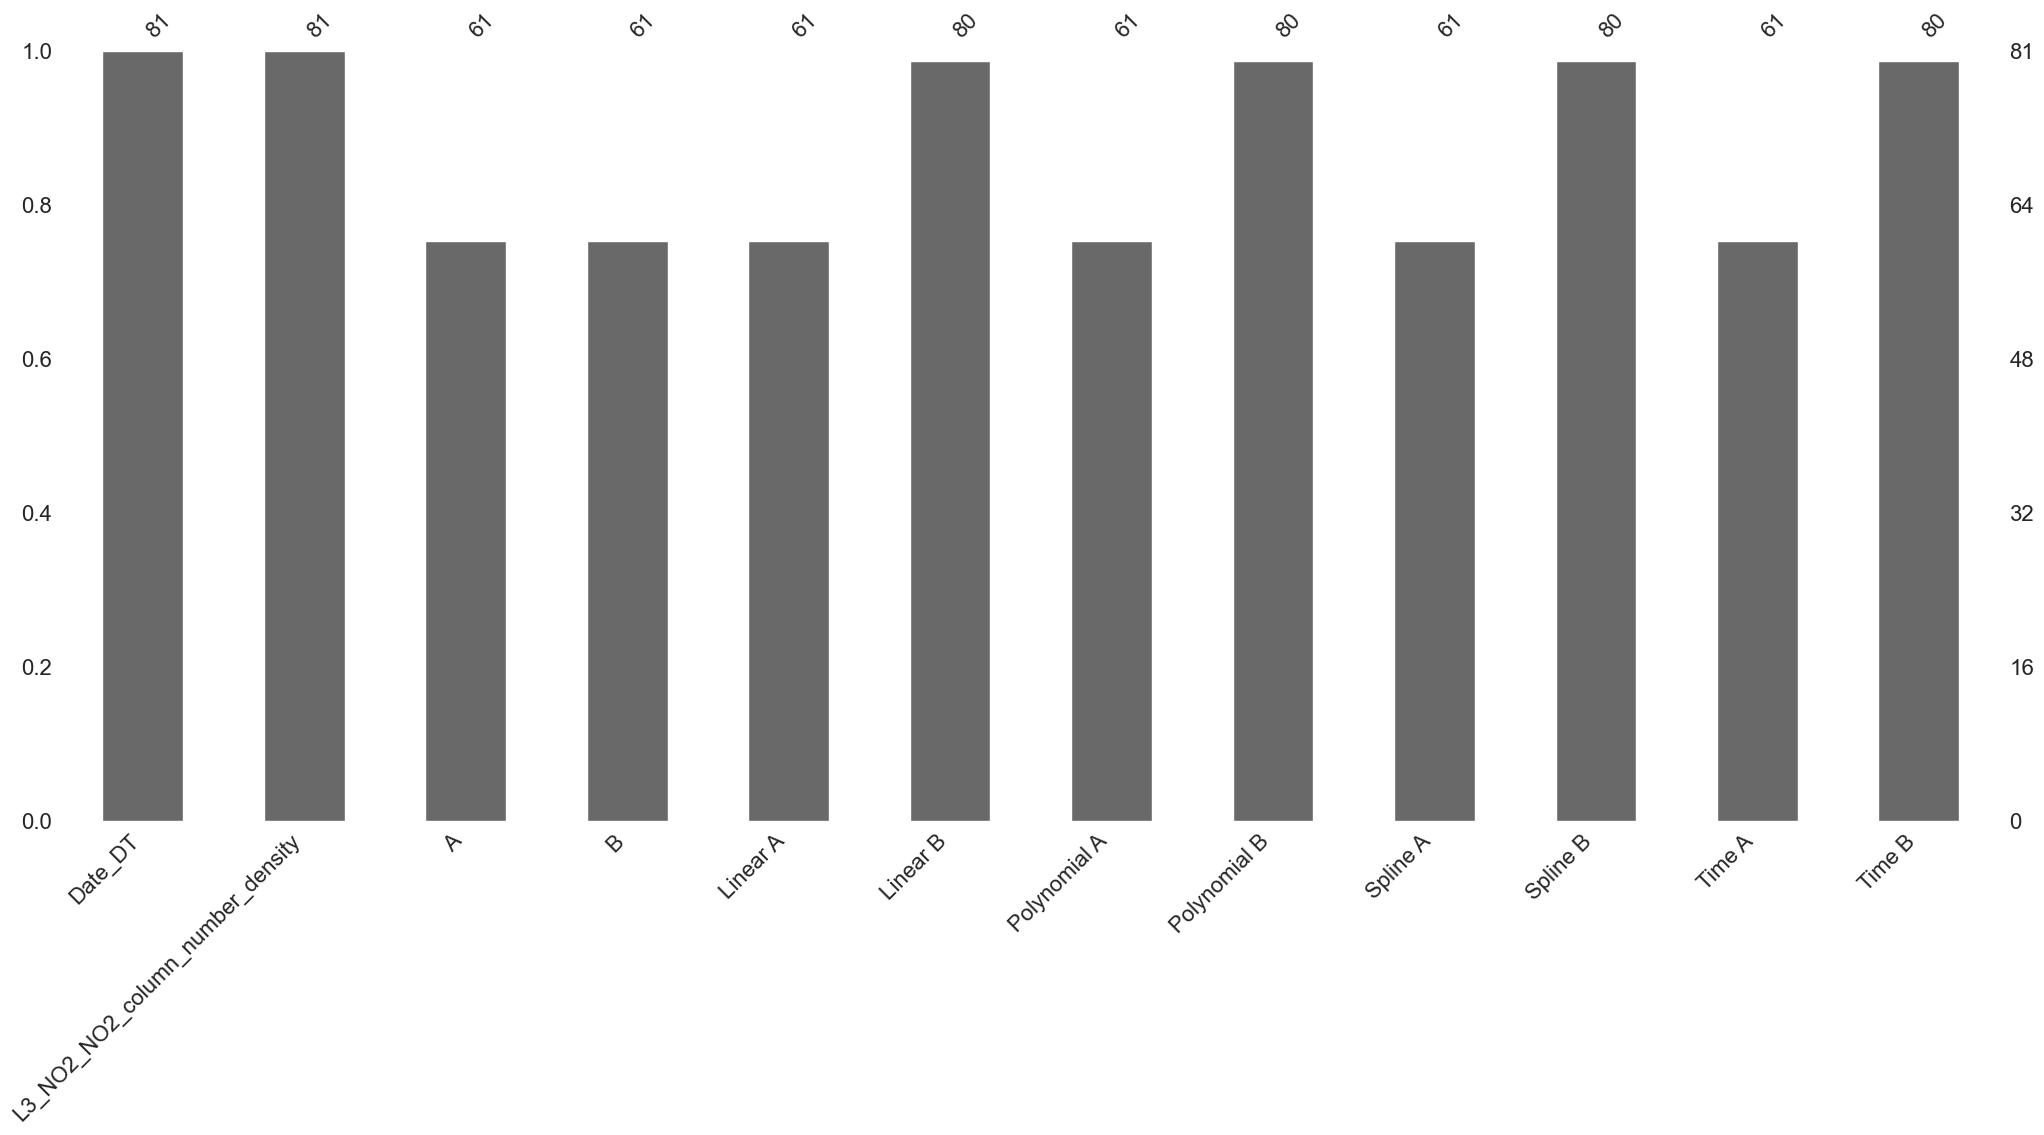

In [63]:
msno.bar(df_null_test)

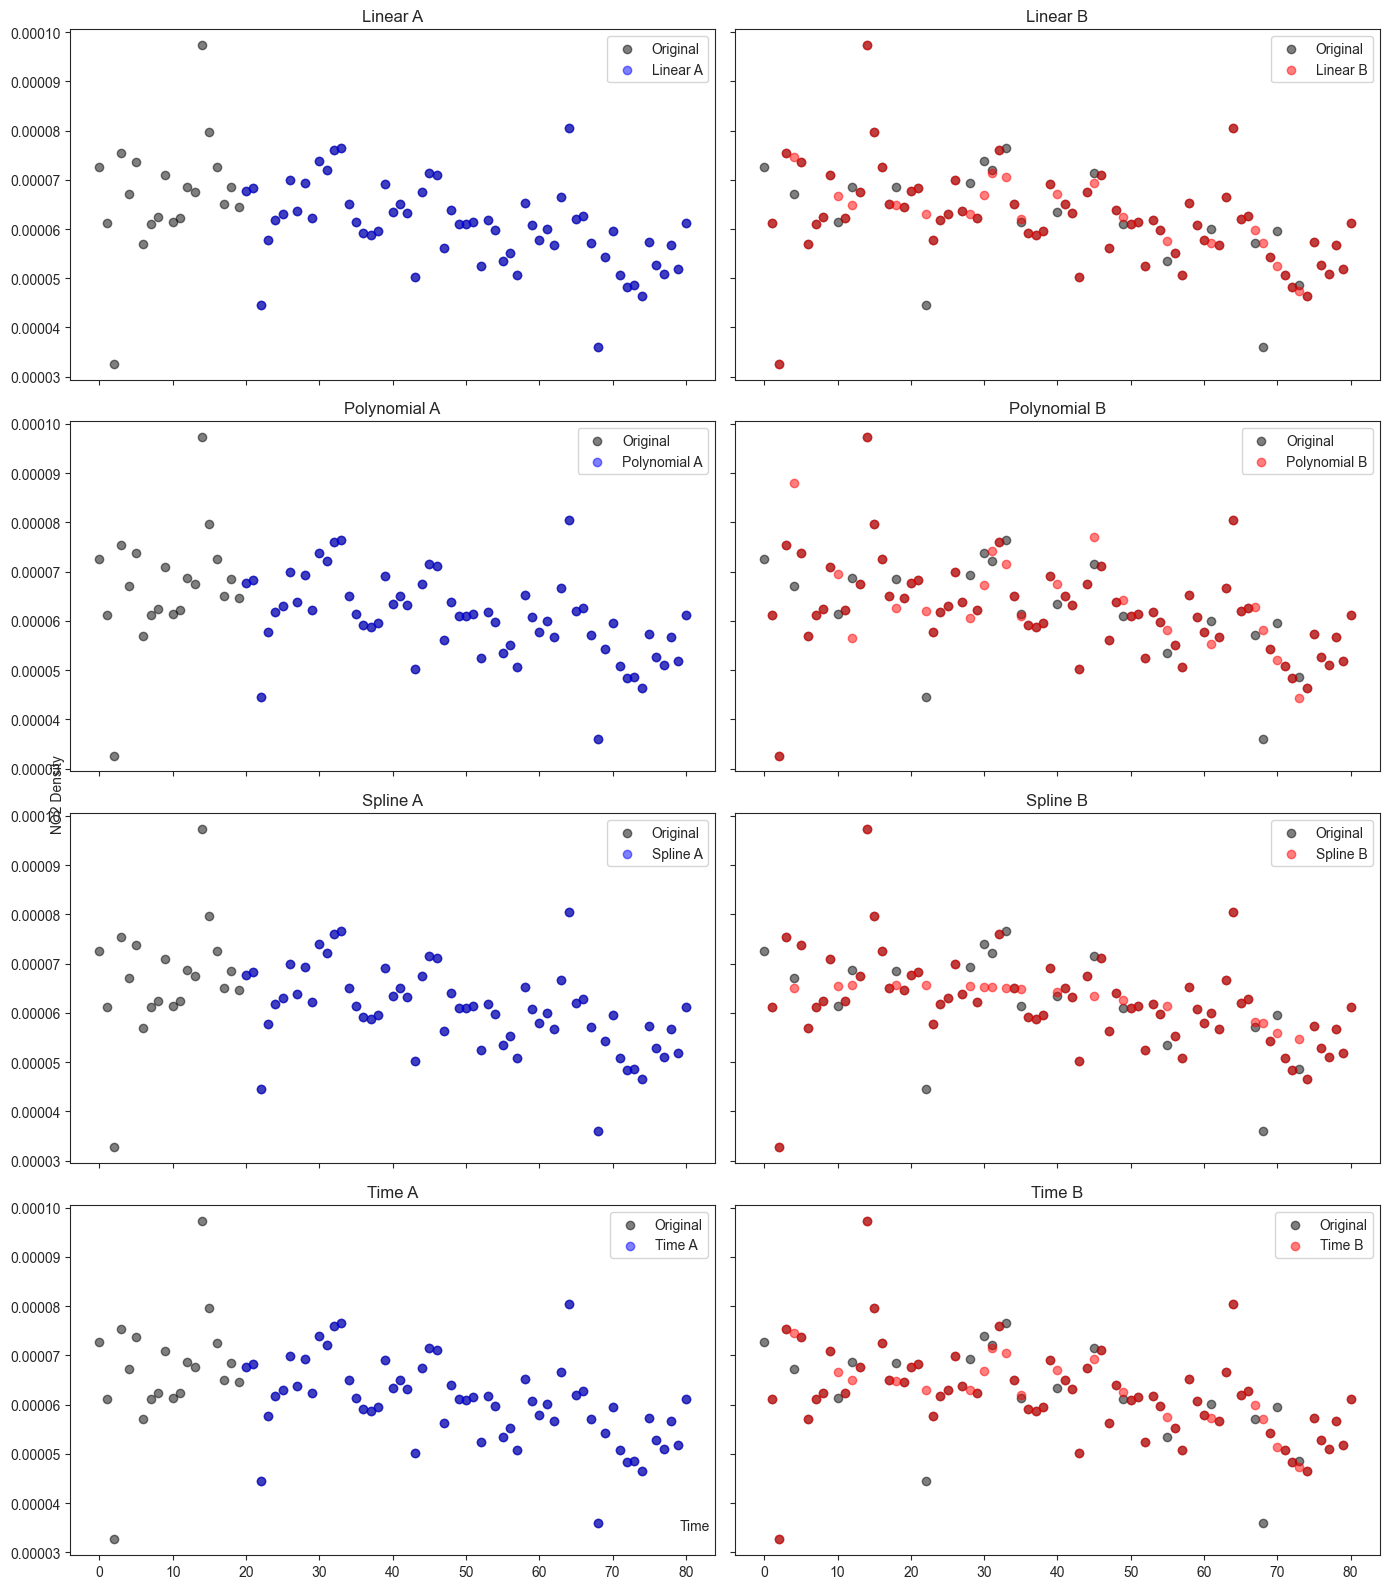

In [64]:
import matplotlib.pyplot as plt

# Prepare the plot with a 4x2 grid
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16), sharex=True, sharey=True)

# Titles for each subplot
titles = ['Linear A', 'Linear B', 'Polynomial A', 'Polynomial B', 
          'Spline A', 'Spline B', 'Time A', 'Time B']

# Data columns for each subplot
column_pairs = [
    ('Linear A', 'Linear B'),
    ('Polynomial A', 'Polynomial B'),
    ('Spline A', 'Spline B'),
    ('Time A', 'Time B')
]

# Loop through each pair and plot them side by side
for i, (col_a, col_b) in enumerate(column_pairs):
    # Determine the row and column for each plot
    row = i
    # Plot A
    axes[row, 0].scatter(df_null_test.index, df_null_test['L3_NO2_NO2_column_number_density'], color='black', label='Original', alpha=0.5)
    axes[row, 0].scatter(df_null_test.index, df_null_test[col_a], color='blue', label=col_a, alpha=0.5)
    axes[row, 0].set_title(titles[2 * i])
    axes[row, 0].legend()

    # Plot B
    axes[row, 1].scatter(df_null_test.index, df_null_test['L3_NO2_NO2_column_number_density'], color='black', label='Original', alpha=0.5)
    axes[row, 1].scatter(df_null_test.index, df_null_test[col_b], color='red', label=col_b, alpha=0.5)
    axes[row, 1].set_title(titles[2 * i + 1])
    axes[row, 1].legend()

# Set common labels
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'NO2 Density', va='center', rotation='vertical')

# Show the plot
plt.tight_layout()
plt.show()

In [68]:
df_null_test.head(40)

Date_DT  L3_NO2_NO2_column_number_density         A         B  Linear A  \
0  2020-01-02                          0.000073       NaN       NaN       NaN   
1  2020-01-03                          0.000061       NaN  0.000061       NaN   
2  2020-01-04                          0.000033       NaN  0.000033       NaN   
3  2020-01-05                          0.000075       NaN  0.000075       NaN   
4  2020-01-06                          0.000067       NaN       NaN       NaN   
5  2020-01-07                          0.000074       NaN  0.000074       NaN   
6  2020-01-08                          0.000057       NaN  0.000057       NaN   
7  2020-01-09                          0.000061       NaN  0.000061       NaN   
8  2020-01-10                          0.000062       NaN  0.000062       NaN   
9  2020-01-11                          0.000071       NaN  0.000071       NaN   
10 2020-01-12                          0.000061       NaN       NaN       NaN   
11 2020-01-13                          0.000062       NaN  0.000062       NaN   
12 2020-01-14                          0.000069       NaN       NaN       NaN   
13 2020-01-15                          0.000068       NaN  0.000068       NaN   
14 2020-01-16                          0.000097       NaN  0.000097       NaN   
15 2020-01-17                          0.000080       NaN  0.000080       NaN   
16 2020-01-18                          0.000073       NaN  0.000073       NaN   
17 2020-01-19                          0.000065       NaN  0.000065       NaN   
18 2020-01-20                          0.000068       NaN       NaN       NaN   
19 2020-01-21                          0.000065       NaN  0.000065       NaN   
20 2020-01-22                          0.000068  0.000068  0.000068  0.000068   
21 2020-01-23                          0.000068  0.000068  0.000068  0.000068   
22 2020-01-24                          0.000044  0.000044       NaN  0.000044   
23 2020-01-25                          0.000058  0.000058  0.000058  0.000058   
24 2020-01-26                          0.000062  0.000062  0.000062  0.000062   
25 2020-01-27                          0.000063  0.000063  0.000063  0.000063   
26 2020-01-28                          0.000070  0.000070  0.000070  0.000070   
27 2020-01-29                          0.000064  0.000064  0.000064  0.000064   
28 2020-01-30                          0.000069  0.000069       NaN  0.000069   
29 2020-01-31                          0.000062  0.000062  0.000062  0.000062   
30 2020-02-01                          0.000074  0.000074       NaN  0.000074   
31 2020-02-02                          0.000072  0.000072       NaN  0.000072   
32 2020-02-03                          0.000076  0.000076  0.000076  0.000076   
33 2020-02-04                          0.000077  0.000077       NaN  0.000077   
34 2020-02-05                          0.000065  0.000065  0.000065  0.000065   
35 2020-02-06                          0.000061  0.000061       NaN  0.000061   
36 2020-02-07                          0.000059  0.000059  0.000059  0.000059   
37 2020-02-08                          0.000059  0.000059  0.000059  0.000059   
38 2020-02-09                          0.000060  0.000060  0.000060  0.000060   
39 2020-02-11                          0.000069  0.000069  0.000069  0.000069   

    Linear B  Polynomial A  Polynomial B  Spline A  Spline B    Time A  \
0        NaN           NaN           NaN       NaN       NaN       NaN   
1   0.000061           NaN      0.000061       NaN  0.000061       NaN   
2   0.000033           NaN      0.000033       NaN  0.000033       NaN   
3   0.000075           NaN      0.000075       NaN  0.000075       NaN   
4   0.000075           NaN      0.000088       NaN  0.000065       NaN   
5   0.000074           NaN      0.000074       NaN  0.000074       NaN   
6   0.000057           NaN      0.000057       NaN  0.000057       NaN   
7   0.000061           NaN      0.000061       NaN  0.000061       NaN   
8   0.000062      

In [66]:
df_null_test_NoNaN = df_null_test.dropna(subset=['Linear B'])

In [67]:
from sklearn.metrics import mean_squared_error, r2_score

# Sample data
true_values = np.array(df_null_test_NoNaN['L3_NO2_NO2_column_number_density'])  #True values
interpolated_values = {
    'linear': np.array(df_null_test_NoNaN['Linear B']),  # Interpolated values from the linear method
    'polynomial': np.array(df_null_test_NoNaN['Polynomial B']),  # Interpolated values from the polynomial method
    'time': np.array(df_null_test_NoNaN['Time B']),  # Interpolated values from the time method
    'spline': np.array(df_null_test_NoNaN['Spline B'])  # Interpolated values from the spline method
}

# Calculate MSE, RMSE, and R² for each method
for method, values in interpolated_values.items():
    mse = mean_squared_error(true_values, values)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, values)
    
    print(f"{method.capitalize()} Interpolation:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print()

Linear Interpolation:
  Mean Squared Error (MSE): 0.0000
  Root Mean Squared Error (RMSE): 0.0000
  R² Score: 0.8475

Polynomial Interpolation:
  Mean Squared Error (MSE): 0.0000
  Root Mean Squared Error (RMSE): 0.0000
  R² Score: 0.7500

Time Interpolation:
  Mean Squared Error (MSE): 0.0000
  Root Mean Squared Error (RMSE): 0.0000
  R² Score: 0.8451

Spline Interpolation:
  Mean Squared Error (MSE): 0.0000
  Root Mean Squared Error (RMSE): 0.0000
  R² Score: 0.8067



## Going back to the main data set df_cleaned

In [ ]:
df_cleaned.set_index(['Place_ID', 'Date_DT'], inplace=True)

In [ ]:
df_cleaned.index

In [ ]:
msno.bar(df_cleaned)

In [ ]:
df_cleaned.columns

In [ ]:
# List of columns to interpolate
columns_to_interpolate = ['target_variance', 'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure', 'L3_O3_O3_column_number_density',
       'L3_O3_O3_effective_temperature', 'L3_O3_cloud_fraction',
       'L3_CO_CO_column_number_density', 'L3_CO_H2O_column_number_density',
       'L3_CO_cloud_height', 'L3_HCHO_HCHO_slant_column_number_density',
       'L3_HCHO_cloud_fraction',
       'L3_HCHO_tropospheric_HCHO_column_number_density',
       'L3_HCHO_tropospheric_HCHO_column_number_density_amf',
       'L3_CLOUD_cloud_base_height', 'L3_CLOUD_cloud_base_pressure',
       'L3_CLOUD_cloud_fraction', 'L3_CLOUD_cloud_optical_depth',
       'L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_top_pressure',
       'L3_CLOUD_surface_albedo', 'L3_AER_AI_absorbing_aerosol_index',
       'L3_AER_AI_sensor_altitude', 'L3_SO2_SO2_column_number_density',
       'L3_SO2_SO2_column_number_density_amf',
       'L3_SO2_SO2_slant_column_number_density',
       'L3_SO2_absorbing_aerosol_index', 'L3_SO2_cloud_fraction']

# Apply the interpolation for each column in the list
df_cleaned[columns_to_interpolate] = df_cleaned.groupby(level='Place_ID')[columns_to_interpolate].transform(lambda group: group.interpolate(method='linear'))


In [ ]:
msno.bar(df_cleaned)

In [ ]:
df_cleaned[df_cleaned.isna().any(axis=1)]

In [ ]:
df_cleaned = df_cleaned.reset_index()

In [ ]:
df_cleaned.shape

In [ ]:
remaining_nans = df_cleaned[df_cleaned.isna().any(axis=1)]
print(f"Rows with remaining NaNs: {len(remaining_nans)}")

In [ ]:
df_cleaned = df_cleaned.dropna()

In [ ]:
df_cleaned.shape

In [ ]:
df_cleaned.to_csv('Train_cleaned_29857.csv', index=False)

In [ ]:
import pandas as pd
df = pd.read_csv('Train_cleaned_29857.csv')

In [ ]:
df['Date_DT'].dtype

# Feature Engineering

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:


# Continuous numerical features
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Binary features
binary_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Ordinal features
ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

# Nominal Categorical features
nominal_cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine all transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('bin', binary_transformer, binary_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('nom', nominal_cat_transformer, cat_features)
    ])
